In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [97]:
def run_sim_and_plot(n, mean_arrival_rate, mean_service_rate):
    params = build_params(n, mean_arrival_rate, mean_service_rate)
    print(f"### Samples n = {n}, " + f"lambda = {params['mean_arrival_rate']}, " + f"mu = {params['mean_service_rate']}.")
    result = run_sim(params) # get data
    plot_result(result) # plot data

def build_params(num, mean_arrival_rate, mean_service_rate):
    return {
        "n": num,
        "mean_arrival_rate": mean_arrival_rate, # lambda = mean_arrival_rate
        "mean_service_rate": mean_service_rate, # mu = mean_service_rate
        "mean_interarrival_time": 1.0 / mean_arrival_rate,
        "mean_service_time": 1.0 / mean_service_rate,
        "num_bins": int(num / mean_arrival_rate)
    }

def run_sim(params):
    samples = params["n"]
    
    mean_service_time = params["mean_service_time"] # get mu for exponential distribution
    mean_arrival_rate = params["mean_arrival_rate"] # get lambda for poisson distribution
    
    interarrival_times = np.random.poisson(lam = mean_arrival_rate, size = samples) # poisson distribution
    arrival_times = np.cumsum(interarrival_times)
    service_times = np.random.exponential(scale = mean_service_time, size = samples) # exponential distribution
    request_df = build_request_df(params, interarrival_times, arrival_times, service_times)
    events_df = build_events_df(params, request_df)
    total_range = get_total_range(request_df)
    
    sim_mean_interarrival_time = request_df["interarrival_time"].mean()
    sim_mean_arrival_rate = 1.0 / sim_mean_interarrival_time
    sim_mean_service_time = request_df["service_time"].mean() # mean service time
    sim_mean_service_rate = 1.0 / sim_mean_service_time
    sim_mean_wait_time = request_df["wait_time"].mean() # mean wait time
    sim_response_time_mean = request_df["response_time"].mean()
    sim_response_time_var = request_df["response_time"].var()
    
    # mean_num_in_system and mean_num_in_queue
    range = events_df["range"]
    total_weighted_num_in_system = (range * events_df["num_in_system"]).sum()
    total_weighted_num_in_queue = (range * events_df["num_in_queue"]).sum()
    sim_mean_num_in_system = total_weighted_num_in_system / total_range
    sim_mean_num_in_queue = total_weighted_num_in_queue / total_range
    
    # throughput mean and variance
    departures = events_df.loc[events_df["num_in_system_change"] == -1.0, "lowerbound"]
    hist, _ = np.histogram(departures, bins=int(total_range) + 1) # data to plot
    sim_throughput_mean = np.mean(hist)
    
    util = estimate_util(request_df)

    return {
        "params": params,
        "request_df": request_df,
        "events_df": events_df,
        "total_duration": total_range,
        "mean_arrival_rate": sim_mean_arrival_rate,
        "mean_interarrival_time": sim_mean_interarrival_time,
        "mean_service_rate": sim_mean_service_rate,
        "mean_service_time": sim_mean_service_time,
        "mean_wait_time": sim_mean_wait_time,
        "response_time_mean": sim_response_time_mean,
        "response_time_var": sim_response_time_var,
        "mean_num_in_system": sim_mean_num_in_system,
        "mean_num_in_queue": sim_mean_num_in_queue,
        "throughput_mean": sim_throughput_mean,
        "utilization": util,
    }

def build_request_df(params, interarrival_times, arrival_times, service_times):    
    samples = params["n"]
    
    request_df = pd.DataFrame({
        "interarrival_time": interarrival_times,
        "arrive_time": arrival_times,
        "service_time": service_times,
        "start_time": np.zeros(samples),
        "depart_time": np.zeros(samples)
    })
    
    request_df.loc[0, "start_time"] = request_df.loc[0, "arrive_time"] # initial
    request_df.loc[0, "depart_time"] = request_df.loc[0, "start_time"] + request_df.loc[0, "service_time"] # depart time = moment + service_time
    
    for i in range(1, samples):
        request_df.loc[i, "start_time"] = max(request_df.loc[i, "arrive_time"], request_df.loc[i-1, "depart_time"]) # if service_time exceeds, jump to service_time. if < arrive_time, jump to arrive_time
        request_df.loc[i, "depart_time"] = request_df.loc[i, "start_time"] + request_df.loc[i, "service_time"] # depart time = moment + service_time
    
    request_df["response_time"] = request_df["depart_time"] - request_df["arrive_time"]
    request_df["wait_time"] = request_df["start_time"] - request_df["arrive_time"] # new group's start time - previous group's start time
        
    return request_df

def build_events_df(params, request_df): # moment (time)
    samples = params["n"]
    arrivals = request_df["arrive_time"]
    starts = request_df["start_time"]
    departures = request_df["depart_time"]
    
    events_df = pd.DataFrame(columns=["lowerbound", "upperbound", "range", "num_in_system", "num_in_queue"])

    lowerbound = 0.0
    arrive_idx = 0
    start_idx = 0
    depart_idx = 0
    num_in_system = 0
    num_in_queue = 0
    
    while depart_idx < samples:
        if arrive_idx < samples:
            arrival = arrivals[arrive_idx]
        else:
            arrival = float("inf")

        if start_idx < samples:
            start = starts[start_idx]
        else:
            start = float("inf")
        
        departure = departures[depart_idx]
                        
        if arrival <= start and arrival <= departure:
            upperbound = arrival 
            n_change, nq_change = 1, 1
            arrive_idx += 1        
        elif start <= arrival and start <= departure:
            upperbound = start
            n_change, nq_change = 0, -1
            start_idx += 1
        else:
            upperbound = departure # sum service time < inter-arrival
            n_change, nq_change = -1, 0
            depart_idx += 1
                
        range = upperbound - lowerbound
        events_df = events_df.append({
            "lowerbound": lowerbound,
            "upperbound": upperbound,
            "range": range,
            "num_in_system": num_in_system,
            "num_in_queue": num_in_queue,
            "num_in_system_change": n_change,
            "num_in_queue_change": nq_change,
        }, ignore_index = True)
        
        num_in_system = num_in_system + n_change
        num_in_queue = num_in_queue + nq_change

        lowerbound = upperbound # move to next step of time
    
    return events_df

def get_total_range(request_df): # range from start to end
    return request_df.iloc[-1]["depart_time"] - request_df.iloc[0]["arrive_time"]

def estimate_util(request_df): # mean utilization
    wait = (request_df["depart_time"] - request_df["start_time"]).sum()
    return wait / get_total_range(request_df)

In [98]:
# PLOTTING FUNCTIONS
def plot_result(result):
    params = result["params"]
    request_df = result["request_df"]
    events_df = result["events_df"]
    
    _plot_request_over_time(events_df)
    plot_arrival_time(request_df["arrive_time"])

def plot_arrival_time(data):
    plt.figure(figsize=(25, 6))
    plt.title("Histogram of arrival times", size = 18)
    plt.xlabel("Arrival time")
    plt.ylabel("Frequency")
    plt.hist(data, bins = 50, edgecolor = "black")
    plt.show()

def _plot_request_over_time(events_df):
    plt.figure(figsize=(25, 6))
    plt.title("Number of requests waiting", size=18)
    plt.xlabel("Time")
    plt.ylabel("Requests")
    plt.plot(events_df["lowerbound"], events_df["num_in_system"])
    plt.show()

### Samples n = 1000, lambda = 1, mu = 4.


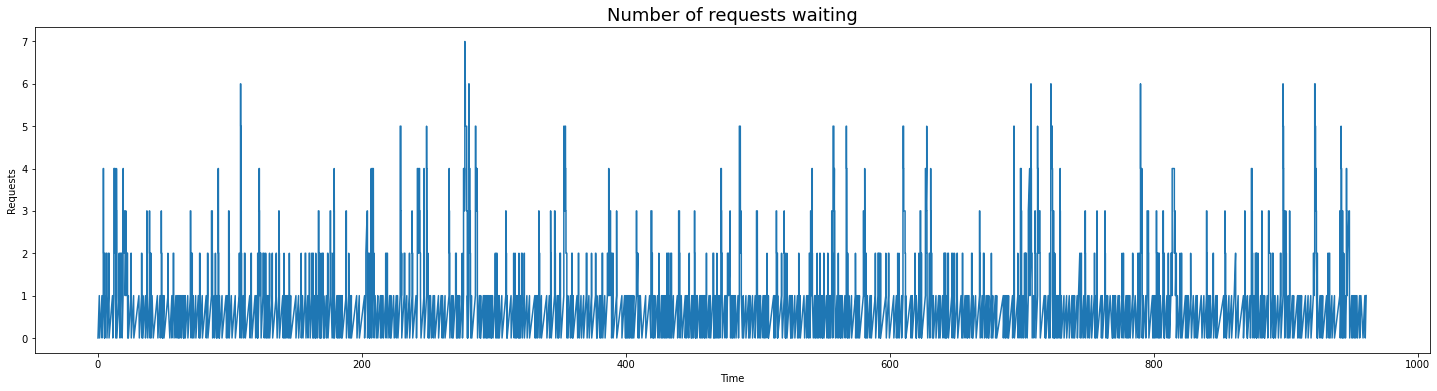

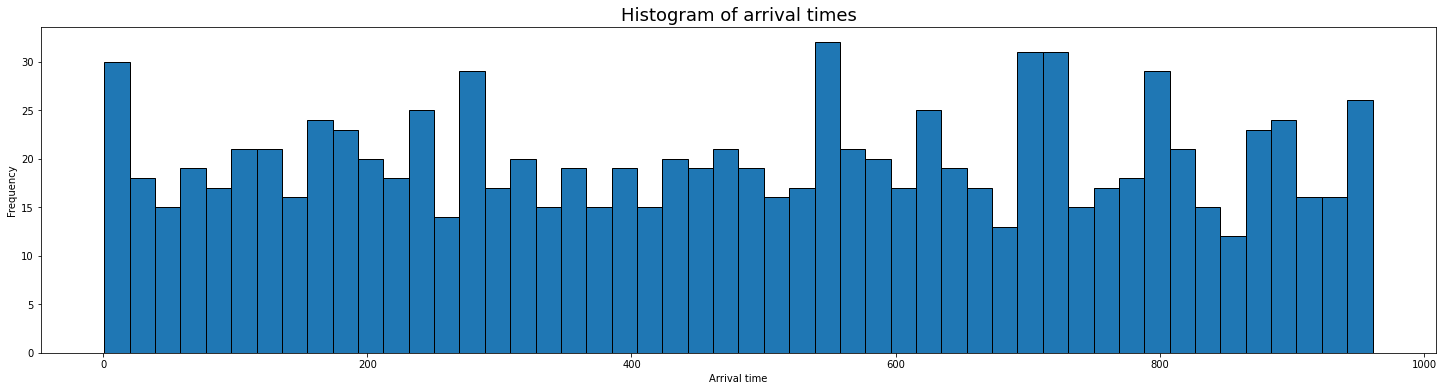

### Samples n = 1000, lambda = 3, mu = 4.


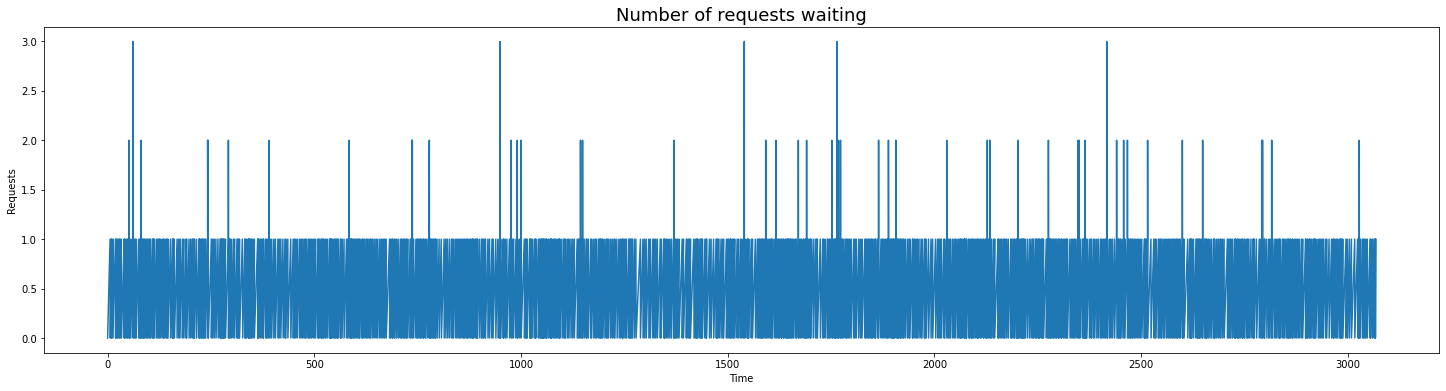

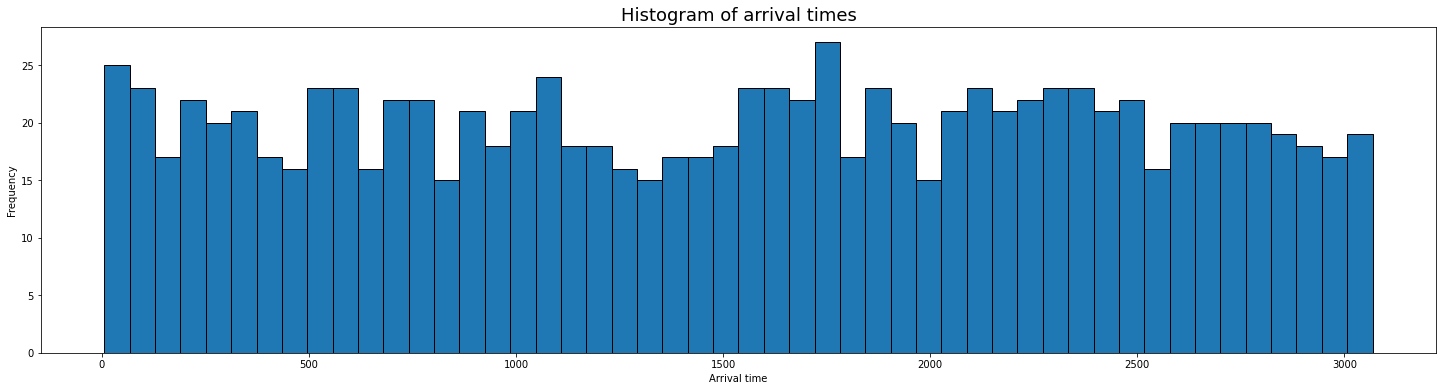

### Samples n = 1000, lambda = 4, mu = 4.


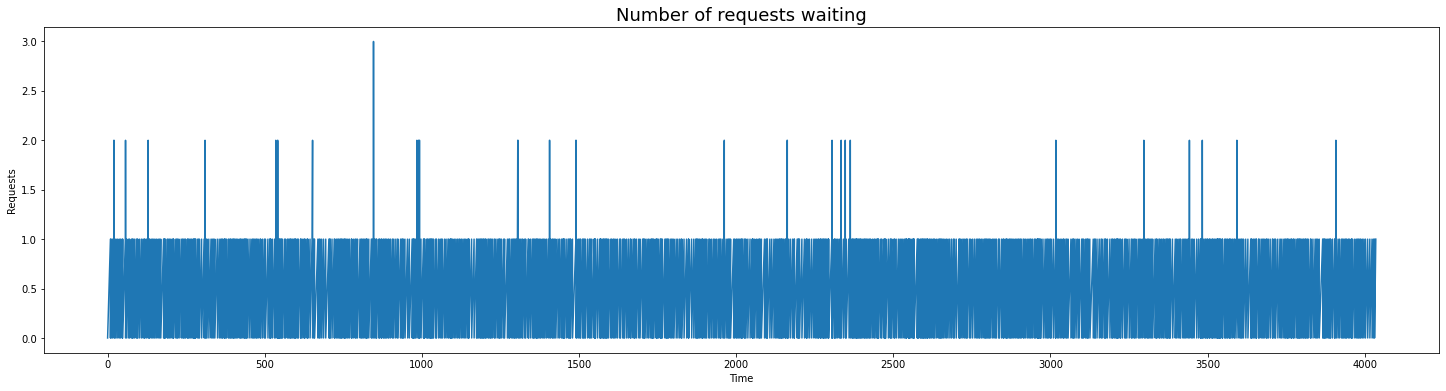

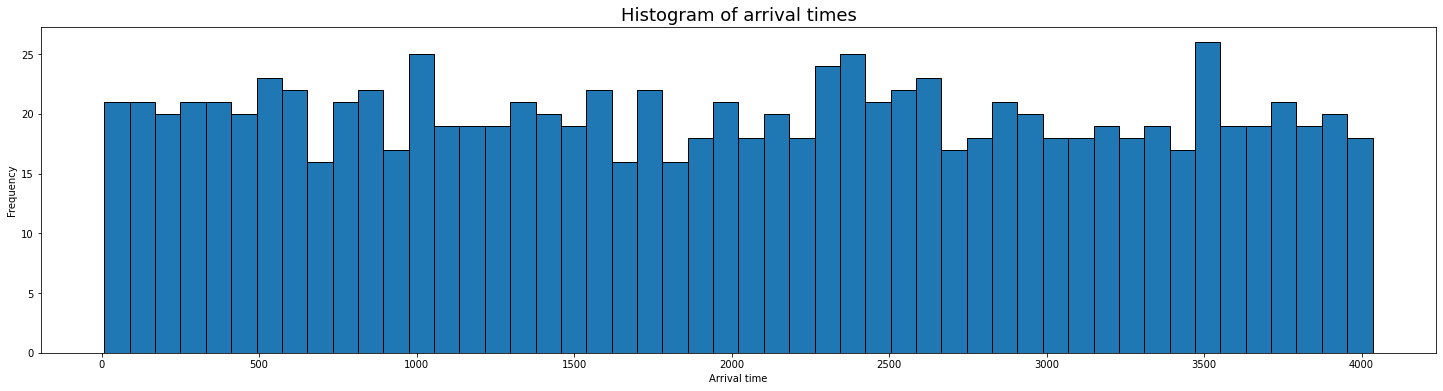

In [99]:
# RUN
for lam in [1, 3, 4]:
    run_sim_and_plot(1000, lam, 4) # mu = 4